In [5]:
#-----------------------------------------
# Problem Set 3: Descriptive Stats
#   Tanya Rajan and George Vojta
#
#-----------------------------------------

# importing packages
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

4.319848464221509
123.98234393640384


(array([357.,  59.,  12.,   7.,   8.,   1.,   0.,   2.,   0.,   1.]),
 array([   4.64385159,  159.82331254,  315.00277348,  470.18223443,
         625.36169537,  780.54115632,  935.72061726, 1090.90007821,
        1246.07953915, 1401.2590001 , 1556.43846104]),
 <BarContainer object of 10 artists>)

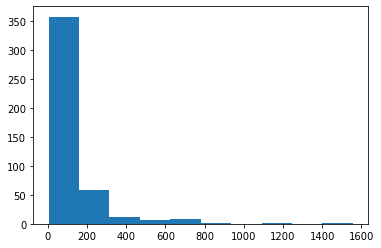

In [7]:
# --------------------------------------
#          Step 1: Find b-hat
# --------------------------------------

# load data
df = pd.read_csv("data/ps3_clean.csv")
df.head()

# preparing data for regression
df['lnbid'] = np.log(df['bid'])
df_exog = df.copy()
df_exog.drop(['bidder', 'lnbid', 'bid', 'auction', 'ident', 'ringwin'], axis=1, inplace=True)

# getting regression coefficients
reg1 = sm.OLS(endog=df['lnbid'], exog=df_exog, missing='drop').fit()
coefs = reg1.params[0:7]

# predicting ln(bhat)
xmat = np.array(df_exog[['cat_price', 'est_min', 'est_max', 'grademin', 'grademax', 'usonly', 'novalue']].copy())
lnbhat = df['lnbid'] - xmat@coefs

# put bhat back into our dataset
print(np.mean(lnbhat))
#bhat = bhat - np.mean(bhat)
df["bhat"] = np.exp(lnbhat)


print(np.mean(df["bhat"]))
plt.hist(df["bhat"])

In [8]:
# --------------------------------------
#       Estimating Distributions
# --------------------------------------
# Note we omit Step 2 because we assume epsilon = 1

# grid at which to eval
grid_low = 0
grid_high = 2000
increment = 10000

x_grid = np.linspace(grid_low, grid_high, increment)


# function to calculate gaussian kernel
def gkernel(x, grid, bandwidth=.1):
    kde = gaussian_kde(x, bw_method = bandwidth / x.std(ddof=1))
    return(kde.evaluate(grid))

# find index
def find_idx(b):
    stepsize = (grid_high - grid_low)/increment
    return(np.int((b - grid_low)/stepsize))

# --------------------------------------
#       Step 3: Selection Correction
# --------------------------------------

# observed distribution of target price when ring wins
h_vec = df.loc[(df["ringwin"] == 1) & (df["targetobs"] == 1), "bhat"]
hbar = gkernel(h_vec, x_grid)
Hbar = np.cumsum(hbar)/np.sum(hbar)

# observed maximum knockout bid distribution
g_vec = df.loc[df["ident"] == 0, "bhat"]
gm = gkernel(g_vec, x_grid)
Gm = np.cumsum(gm)/np.sum(gm)

# calculating A
def A_fn(x):
    idx = find_idx(x)
    return(hbar[idx]/(1 - Gm[idx]))

trimlow = 5
trimhigh = 1100

A = 1/sp.integrate.quad(A_fn, trimlow, trimhigh)[0]

# Calculating selection-corrected H functions
lowidx = find_idx(trimlow)
highidx = find_idx(trimhigh)

hr = A*(hbar[lowidx:highidx]/(1-Gm[lowidx:highidx]))
Hr = np.cumsum(hr)/np.sum(hr)



<ipython-input-8-984dde2df8cc>:46: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  A = 1/sp.integrate.quad(A_fn, trimlow, trimhigh)[0]


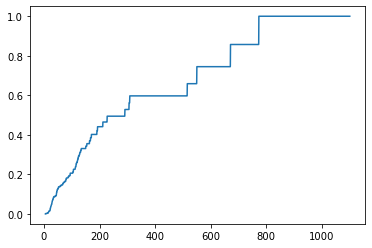

In [9]:
plt.plot(x_grid[lowidx:highidx], Hr)

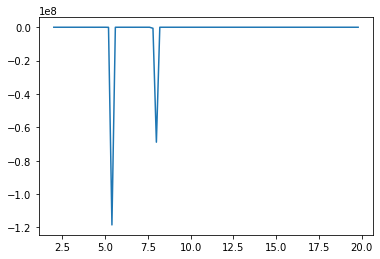

In [12]:
# ----------------------------------------
#       Step 4: Empirical Distributions
# ----------------------------------------

# distributions for beta_1, beta_2, and r
emp_dists = np.zeros((x_grid.size, 3))
for i in range(3):
    i_vec = df.loc[df["ident"] == i, "bhat"]
    emp_dists[:,i] = gkernel(i_vec, x_grid)
    
#plt.plot(x_grid, emp_dists[:,0])

# distributions for each of the 11 bidders
bid_dists = np.zeros((x_grid.size, 11))
for i in range(11):
    idx = i + 1
    i_vec = df.loc[df["bidder"] == idx, "bhat"]
    if i_vec.size == 1:
        xval = find_idx(np.mean(i_vec))
        bid_dists[xval,i] = 1
    else:
        bid_dists[:,i] = gkernel(i_vec, x_grid)
        
bid_cdfs = np.cumsum(bid_dists, axis=0)/np.sum(bid_dists, axis=0)

#plt.plot(x_grid, bid_dists[:,9])

# construct alphas
α = np.array(df.groupby("bidder")["bid"].count())
α = α / df.loc[df["targetobs"] == 0].shape[0]

# construct others' distributions
G_other = np.zeros((x_grid.size, 11))
g_other = np.zeros((x_grid.size, 11))
for i in range(11):
    idxs = list(range(11))
    idxs.pop(i)
    bids_F = bid_cdfs[:,idxs]
    bids_f = bid_dists[:,idxs]
    alphas = α[idxs]
    G_other[:,i] = (bids_F @ alphas) / np.sum(alphas)
    g_other[:,i] = (bids_f @ alphas) / np.sum(alphas)
    
# put it together to get v_ik
G_other = G_other[lowidx:highidx]
g_other = g_other[lowidx:highidx]

def construct_value(b, bidder):
    idx = find_idx(b)
    numerator = (1/2)*Hr[idx]*(1 - G_other[idx, bidder])
    denom1 = hr[idx]*G_other[idx,bidder]
    denom2 = Hr[idx]*g_other[idx,bidder]
    #return(b - numerator/(denom1 + denom2))
    return(b - numerator/(denom1 + denom2))


hi = lambda b: construct_value(b, 10)
hi2 = np.vectorize(hi)

feed_bids = df.loc[df["targetobs"] == 0, "bhat"]

plt.plot(x_grid[10:100],hi2(x_grid[10:100]))

In [3]:
plt.plot(x_grid[lowidx:highidx], G_other[:,1])

NameError: name 'x_grid' is not defined

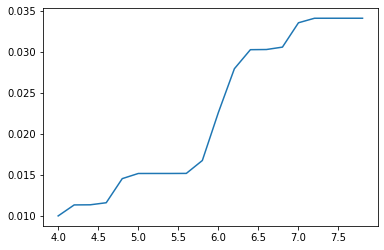

In [251]:
plt.plot(x_grid[20:40], G_other[20:40,1])